In [22]:
import pandas as pd

YEARS = [2018, 2019]

data = pd.DataFrame()

#ingest
for year in YEARS:
    data = data.append(pd.read_csv(f"data/play_by_play_cleaned_{year}.csv.gz", compression='gzip', low_memory=False).reset_index(drop=True), sort=True)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 300)
data.reset_index(drop=True, inplace=True)

In [23]:
data.loc[ (data.play_type!="no_play") ].reset_index(drop=True, inplace=True)
data['wp'] = data['wp'].apply(lambda x: x*100)

In [24]:
import numpy as np
def epa_success(epa):
    return 1 if epa>0 else 0
buckets = 10
wp_bins = pd.IntervalIndex.from_tuples([(100//buckets*i, 100//buckets*(i+1)) for i in range(buckets)])
data['wp'] = pd.cut(data['wp'], wp_bins)

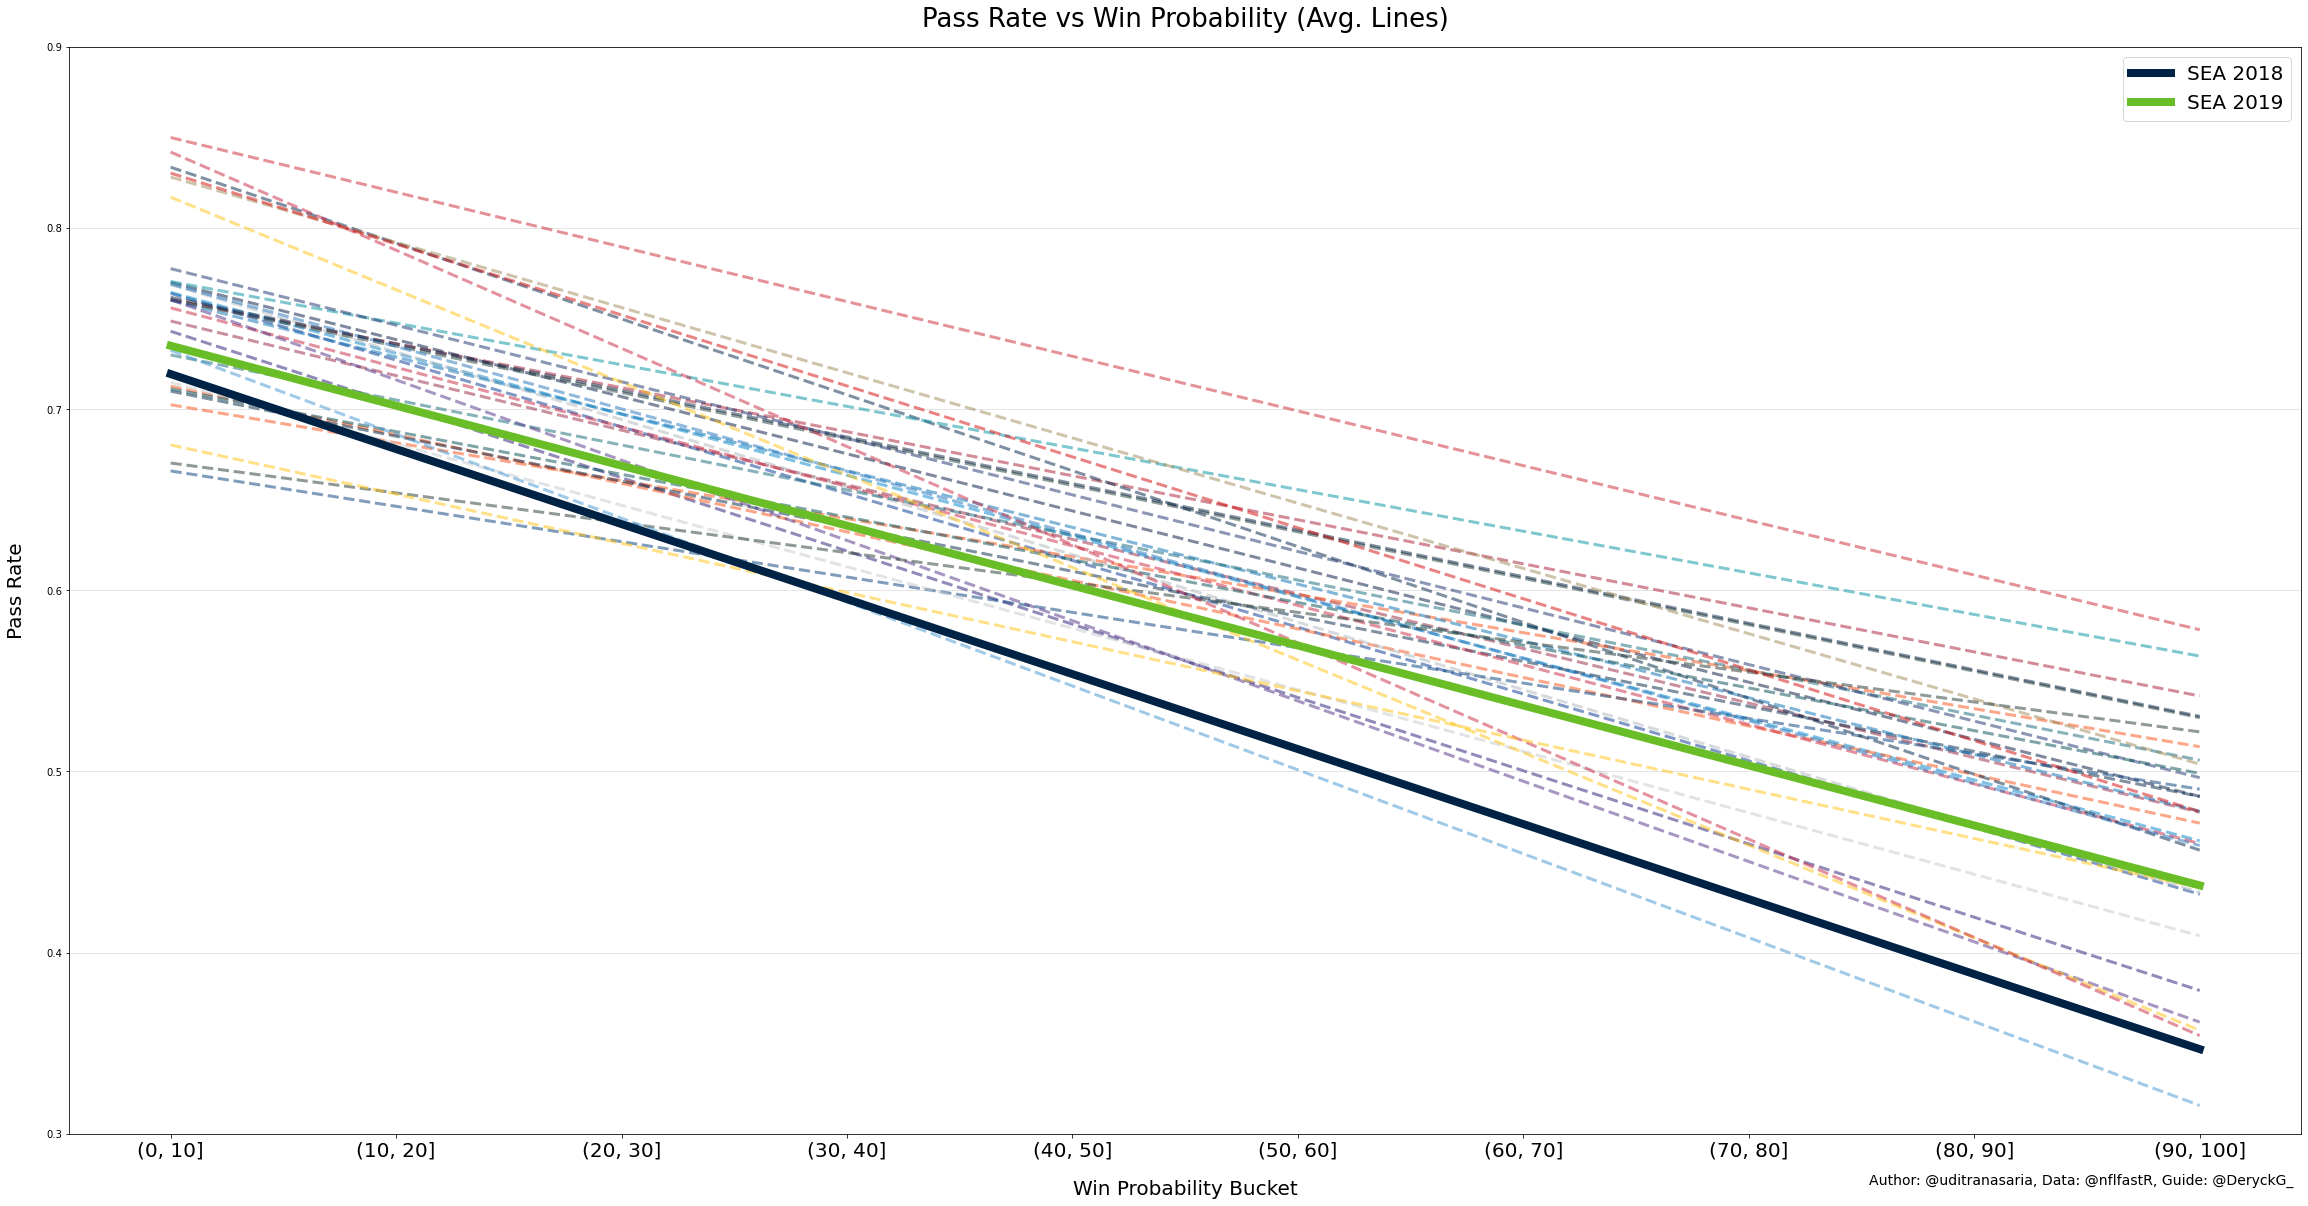

In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=.5)
def trendLineString(z):
    return "y=%.6fx+(%.6f)"%(z[0],z[1])
SEA1 = '#002244'
SEA2 = '#69BE28'
COLORS = {'ARI':'#97233F','ATL':'#A71930','BAL':'#241773','BUF':'#00338D','CAR':'#0085CA','CHI':'#00143F',
          'CIN':'#FB4F14','CLE':'#FB4F14','DAL':'#B0B7BC','DEN':'#002244','DET':'#046EB4','GB':'#24423C',
          'HOU':'#C9243F','IND':'#003D79','JAX':'#136677','KC':'#CA2430','LA':'#002147','LAC':'#2072BA',
          'LV':'#C4C9CC','MIA':'#0091A0','MIN':'#4F2E84','NE':'#0A2342','NO':'#A08A58','NYG':'#192E6C',
          'NYJ':'#203731','PHI':'#014A53','PIT':'#FFC20E','SEA':'#69BE28','SF':'#C9243F','TB':'#D40909',
          'TEN':'#4095D1','WAS':'#FFC20F'}
TEAMS = list(COLORS.keys())
TEAMS.remove('SEA')
# TEAMS.append('SEA')

lines = [] # (team, z, p)

fig, ax = plt.subplots(figsize=(40,20))
x = np.arange(0,len(wp_bins))
for TEAM in TEAMS:
    sea = data.loc[(data.posteam==TEAM)]
    
    by_wp = sea.groupby(['season', 'posteam', 'wp']).agg(
                    play_count = ('play_id', 'count'),
                    pass_rate = ('pass', 'mean'),
                    total_epa = ('epa', 'sum'),
                    avg_epa = ('epa', 'mean'),
                    epa_succ_rate = ('epa', lambda x: (x.map(epa_success).mean()))
                ).round(2).reset_index()

    y = np.array(by_wp['pass_rate'].loc[(by_wp.season==2019)])
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    lines.append((TEAM, z, p))
    
#     fig, ax = plt.subplots(figsize=(40,20))
    w = 2 if TEAM!='SEA' else 10
#     ax.plot(x,y,color=COLORS[TEAM], label=TEAM, linewidth=w)

ax.set_xticks(x)
ax.set_xticklabels(by_wp.wp.map(str), fontsize=20)

for (TEAM, z, p) in lines:
    ax.plot(x, p(x), color=COLORS[TEAM], linestyle='--', linewidth=3, alpha=0.5)
#     tr_line = trendLineString(z)
#     plt.figtext(.75,.85,tr_line,fontsize=16, color=COLORS[TEAM])

sea = data.loc[(data.posteam=='SEA')]

by_wp = sea.groupby(['season', 'posteam', 'wp']).agg(
                play_count = ('play_id', 'count'),
                pass_rate = ('pass', 'mean'),
                total_epa = ('epa', 'sum'),
                avg_epa = ('epa', 'mean'),
                epa_succ_rate = ('epa', lambda x: (x.map(epa_success).mean()))
            ).round(2).reset_index()
# y1 = np.array(by_wp['pass_rate'].loc[(by_wp.season==2018)])
y = np.array(by_wp['pass_rate'].loc[(by_wp.season==2018)])
y2 = np.array(by_wp['pass_rate'].loc[(by_wp.season==2019)])
z = np.polyfit(x, y, 1)
z2 = np.polyfit(x, y2, 1)
p = np.poly1d(z)
p2 = np.poly1d(z2)
lines.append(('SEA', z2, p2))

ax.plot(x, p(x), color=SEA1, label='SEA 2018', linewidth=8, alpha=1)
ax.plot(x, p2(x), color=SEA2, label='SEA 2019', linewidth=8, alpha=1)

ax.grid(zorder=0,alpha=.4,axis='y')
ax.set_ylim(0.3, 0.9)
ax.set_axisbelow(True)
ax.legend(fontsize=20)

TEAM= "All"
ax.set_ylabel('Pass Rate',fontsize=20,labelpad=20)
ax.set_xlabel('Win Probability Bucket',fontsize=20,labelpad=20)
title = f'Pass Rate vs Win Probability (Avg. Lines)'
ax.set_title(title, fontsize=26,pad=20)
plt.figtext(.75,.09,'Author: @uditranasaria, Data: @nflfastR, Guide: @DeryckG_',fontsize=14)

plt.savefig(f'./saved/PRvsWP/{title}.png', dpi=200)
plt.show()


# TEAM = "ALL"
# ax.set_ylabel('Pass Rate',fontsize=20,labelpad=20)
# ax.set_xlabel('Win Probability Bucket',fontsize=20,labelpad=20)
# title = f'{TEAM} Pass Rate vs Win Probability {YEARS}'
# ax.set_title(title, fontsize=26,pad=20)
# plt.figtext(.65,.05,'Author: @uditranasaria, Data: @nflfastR, Guide: @DeryckG_',fontsize=14)

# # #League average line label
# # plt.text(31,nflavg+.01,'NFL Average',fontsize=14)
# plt.savefig(f'./saved/PRvsWP/{title}.png', dpi=400)
# plt.show()

In [10]:
list(enumerate(map(lambda x: (x[0], x[1][0]), sorted(lines, key=lambda x: x[1][0]))))

[(0, ('SF', -0.05418181818181815)),
 (1, ('PIT', -0.051090909090909055)),
 (2, ('TEN', -0.04630303030303024)),
 (3, ('MIN', -0.04430303030303028)),
 (4, ('LA', -0.04187878787878786)),
 (5, ('BAL', -0.04042424242424236)),
 (6, ('TB', -0.039151515151515104)),
 (7, ('DAL', -0.03727272727272726)),
 (8, ('BUF', -0.0368484848484848)),
 (9, ('NO', -0.03599999999999993)),
 (10, ('LAC', -0.03442424242424238)),
 (11, ('LV', -0.03393939393939393)),
 (12, ('CAR', -0.03363636363636361)),
 (13, ('SEA', -0.033090909090909074)),
 (14, ('HOU', -0.032848484848484835)),
 (15, ('CHI', -0.031515151515151475)),
 (16, ('DET', -0.03133333333333331)),
 (17, ('NYG', -0.0312121212121212)),
 (18, ('KC', -0.030181818181818136)),
 (19, ('ARI', -0.030121212121212028)),
 (20, ('WAS', -0.027151515151515097)),
 (21, ('CIN', -0.026787878787878777)),
 (22, ('NE', -0.025696969696969628)),
 (23, ('GB', -0.02563636363636359)),
 (24, ('DEN', -0.024848484848484814)),
 (25, ('JAX', -0.024848484848484814)),
 (26, ('ATL', -0.024